In [1]:
from darts import TimeSeries
from datetime import datetime

from dateutil.parser import parse
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf

import os
import torch
import shutil
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from darts.metrics import mape
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5

## 1. 데이터 로드

### 1-1. 데이터 변경 사항

- 날짜 인덱스를 6초 간격으로 변경 (1분 당 10개의 데이터)
- TAG와 상관관계가 낮은 MELT_WEIGHT의 경우 제외
- 무의미한 NUM 제외
- 불량 데이터(TAG가 'NG'인 데이터)는 제외함

### 1-2. 데이터 정보
총 658133 개
결측값은 불량 데이터

In [20]:
df = pd.read_csv('./public/data/raw_data.csv')

df['TAG'] = df['TAG'] == 'NG'

df.index = pd.date_range(start='3/4/2020', end='5/1/2020', freq='6S')[:-1]

df.drop(columns='STD_DT', inplace=True)
df.drop(columns='NUM', inplace=True)
df.drop(columns='MELT_WEIGHT', inplace=True)

df = df.astype(np.float32)
df['TAG'] = df['TAG'].astype(bool)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Freq: 6S
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   835200 non-null  float32
 1   MOTORSPEED  835200 non-null  float32
 2   INSP        835200 non-null  float32
 3   TAG         835200 non-null  bool   
dtypes: bool(1), float32(3)
memory usage: 16.7 MB


,MELT_TEMP,MOTORSPEED,INSP
count,835200.000000,835200.000000,835200.000000
mean,509.200714,459.783020,3.194854
std,128.277512,639.436401,0.011822
min,308.000000,0.000000,3.170000
25%,430.000000,119.000000,3.190000
50%,469.000000,168.000000,3.190000
75%,502.000000,218.000000,3.200000
max,832.000000,1804.000000,3.230000


In [21]:
df_ = df.copy(False)

abnormal_index_list = df[df['TAG'] == True].index

for add in [x for x in range(-24, 25, 6)]:
    df_.loc[abnormal_index_list + pd.Timedelta(seconds=add), 'TAG'] = True

index = (df_['TAG'] == False) & ((df_.index.month == 3) | ((df_.index.month == 4) & (df_.index.day <= 5)))

train_df = df_[index]

val_index = (df.index.month == 4) & (df.index.day <= 10) & (df.index.day > 5)

val_df = df[val_index]

In [22]:
train_df

,MELT_TEMP,MOTORSPEED,INSP,TAG
2020-03-04 00:00:00,489.0,116.0,3.19,False
2020-03-04 00:00:06,433.0,78.0,3.19,False
2020-03-04 00:00:12,464.0,154.0,3.19,False
2020-03-04 00:00:18,379.0,212.0,3.19,False
2020-03-04 00:00:24,798.0,1736.0,3.21,False
...,...,...,...,...
2020-04-05 22:50:24,761.0,1739.0,3.22,False
2020-04-05 22:50:30,731.0,1723.0,3.22,False
2020-04-05 22:50:36,375.0,212.0,3.19,False
2020-04-05 23:24:36,395.0,214.0,3.18,False


In [23]:
train_x_df = train_df.copy(False)
train_y_df = pd.DataFrame(train_x_df.pop('TAG'), columns=['TAG'])

val_x_df = val_df.copy(False)
val_y_df = pd.DataFrame(val_x_df.pop('TAG'), columns=['TAG'])

train_x_df

,MELT_TEMP,MOTORSPEED,INSP
2020-03-04 00:00:00,489.0,116.0,3.19
2020-03-04 00:00:06,433.0,78.0,3.19
2020-03-04 00:00:12,464.0,154.0,3.19
2020-03-04 00:00:18,379.0,212.0,3.19
2020-03-04 00:00:24,798.0,1736.0,3.21
...,...,...,...
2020-04-05 22:50:24,761.0,1739.0,3.22
2020-04-05 22:50:30,731.0,1723.0,3.22
2020-04-05 22:50:36,375.0,212.0,3.19
2020-04-05 23:24:36,395.0,214.0,3.18


### 1-3. 시계열 데이터로 변환

- 결측값에 대한 해결이 필요함

In [24]:
train_x_series = TimeSeries.from_dataframe(train_x_df, freq='6S', fill_missing_dates=True)
train_y_series = TimeSeries.from_dataframe(train_y_df, freq='6S', fill_missing_dates=True)
val_x_series = TimeSeries.from_dataframe(val_x_df, freq='6S', fill_missing_dates=True)
val_y_series = TimeSeries.from_dataframe(val_y_df, freq='6S', fill_missing_dates=True)

len(train_x_series), len(val_x_series) 

(474934, 72000)

### 1-4. Scaling

In [37]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, robust_scale

scaler = Scaler(scaler=MinMaxScaler())

train_scaled = scaler.fit_transform(train_x_series)
val_scaled = scaler.transform(val_x_series)

train_scaled = train_scaled.astype(np.float32)
val_scaled = val_scaled.astype(np.float32)
total_scaled = scaler.transform(TimeSeries.from_dataframe(df.drop(columns=['TAG']), freq='6S', fill_missing_dates=True)).astype(np.float32)

train_scaled.pd_dataframe().info()
val_scaled.pd_dataframe().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 474934 entries, 2020-03-04 00:00:00 to 2020-04-05 23:33:18
Freq: 6S
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   189597 non-null  float32
 1   MOTORSPEED  189597 non-null  float32
 2   INSP        189597 non-null  float32
dtypes: float32(3)
memory usage: 9.1 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72000 entries, 2020-04-06 00:00:00 to 2020-04-10 23:59:54
Freq: 6S
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MELT_TEMP   72000 non-null  float32
 1   MOTORSPEED  72000 non-null  float32
 2   INSP        72000 non-null  float32
dtypes: float32(3)
memory usage: 1.4 MB


## 2. 모델 최초 학습

### 2-1. 결측치 제외

In [29]:
from darts.utils.missing_values import extract_subseries

window_size = 20

train_scaled_list = extract_subseries(train_scaled)

train_scaled_list = [x for x in train_scaled_list if len(x) > window_size]

train_scaled_list

[<TimeSeries (DataArray) (time: 188729, component: 3, sample: 1)>
 array([[[0.33984375],
         [0.06455203],
         [0.33333588]],
 
        [[0.23046875],
         [0.04340568],
         [0.33333588]],
 
        [[0.29101562],
         [0.08569839],
         [0.33333588]],
 
        ...,
 
        [[0.09570312],
         [0.11129661],
         [0.16666794]],
 
        [[0.31054688],
         [0.09794102],
         [0.33333588]],
 
        [[0.24804688],
         [0.03895381],
         [0.33333588]]], dtype=float32)
 Coordinates:
   * time       (time) datetime64[ns] 2020-03-04 ... 2020-03-17T02:32:48
   * component  (component) object 'MELT_TEMP' 'MOTORSPEED' 'INSP'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (time: 81, component: 3, sample: 1)>
 array([[[0.16992188],
         [0.04730106],
         [0.33333588]],
 
        [[0.3359375 ],
         [0.05843072],
         [0.33333588]],
 

In [70]:
import torch.nn as nn

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

from darts.models import TransformerModel

model_name = 'transformer'
epoch = 10

model = TransformerModel(
    input_chunk_length=window_size,
    output_chunk_length=1,
    batch_size=256,
    dropout=0.05,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    loss_fn=RMSELoss(),
    model_name=model_name,
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0]
    }
)

In [71]:
for i, x in enumerate(train_scaled_list):
    if i > 0:
        model = model.load(f'./models/{model_name}/{model_name}.pt')
    model.fit(series=x,epochs=epoch)
    model.save(f'./models/{model_name}/{model_name}.pt')


2022-11-04 15:40:13 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-04 15:40:13 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-04 15:40:13 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-04 15:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-04 15:40:13 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | RMSELoss            | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
--------------------

Training: 0it [00:00, ?it/s]

2022-11-04 15:47:36 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-04 15:47:36 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-04 15:47:36 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-04 15:47:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-04 15:47:36 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
--------------------

Training: 0it [00:00, ?it/s]

2022-11-04 15:47:37 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-04 15:47:37 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-04 15:47:37 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-04 15:47:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-04 15:47:37 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
--------------------

Training: 0it [00:00, ?it/s]

2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-04 15:47:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-04 15:47:38 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
--------------------

Training: 0it [00:00, ?it/s]

2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-04 15:47:38 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-04 15:47:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-11-04 15:47:38 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
--------------------

Training: 0it [00:00, ?it/s]

In [56]:
prediction = model.predict(n=100, series=total_scaled[:-100])

prediction

2022-11-04 14:15:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1it [00:00, ?it/s]

<TimeSeries (DataArray) (time: 100, component: 3, sample: 1)>
array([[[ 2.5067595e-01],
        [-1.0197766e-02],
        [ 3.6045325e-01]],

       [[ 2.5564110e-01],
        [-2.3626462e-03],
        [ 3.6286756e-01]],

       [[ 2.5379002e-01],
        [ 8.3293766e-04],
        [ 3.5842037e-01]],

       [[ 1.8847121e-01],
        [ 3.9205864e-02],
        [ 2.8834480e-01]],

       [[ 6.4739555e-01],
        [ 6.5201509e-01],
        [ 5.4477566e-01]],

...

       [[ 6.4878851e-01],
        [ 6.5234494e-01],
        [ 5.4619485e-01]],

       [[ 2.2515145e-01],
        [ 7.4407011e-03],
        [ 3.3454534e-01]],

       [[ 2.5894889e-01],
        [ 4.8904344e-03],
        [ 3.6287591e-01]],

       [[ 2.5499505e-01],
        [-4.8777685e-03],
        [ 3.6290714e-01]],

       [[ 2.5548765e-01],
        [-3.3725724e-03],
        [ 3.6292750e-01]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-04-30T23:50:00 ... 2020-04-30T23:59:54
  * component  (component) object 'MELT_TEMP' 'MOTORSPEED' 'INSP'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

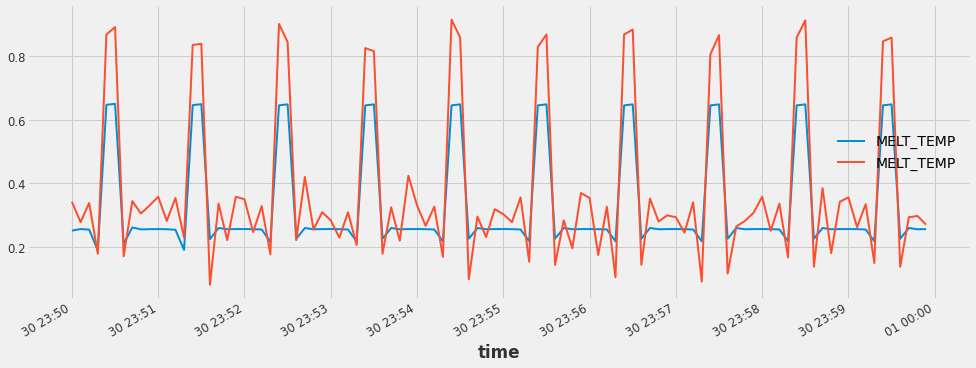

In [57]:
col = 'MELT_TEMP'

index = prediction[col].time_index

a = total_scaled[index]
prediction[col].plot()
(a[col]).plot()
# real_time_x_series['MOTORSPEED'].plot()

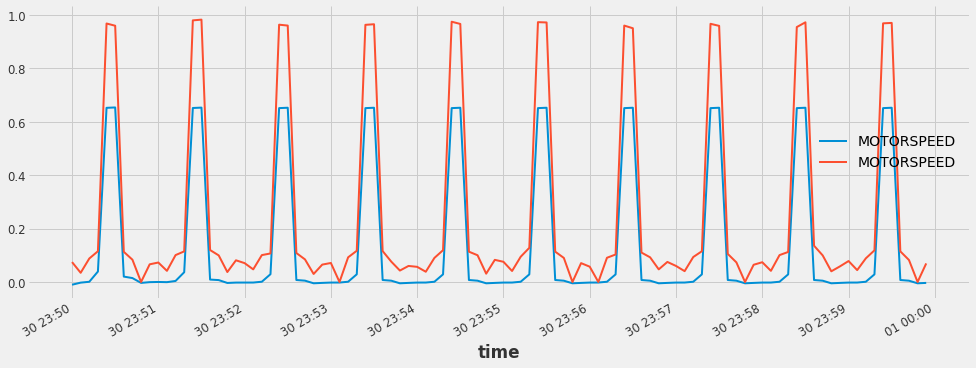

In [58]:
col = 'MOTORSPEED'

index = prediction[col].time_index

a = total_scaled[index]
prediction[col].plot()
(a[col]).plot()

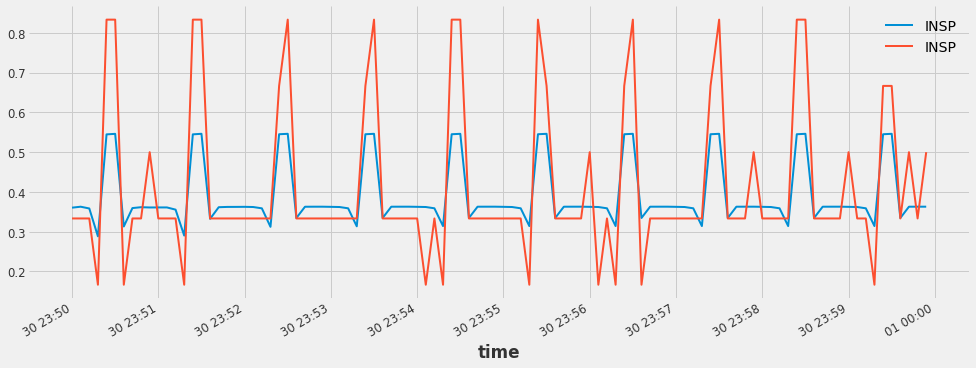

In [59]:
col = 'INSP'

index = prediction[col].time_index

a = total_scaled[index]
prediction[col].plot()
(a[col]).plot()